## Notes on parameterising a circle in 3D and converting to spherical polar coordinates

In [2]:
import pathlib
import re

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.signal import medfilt

In [3]:
pwd

'/mnt/eps01-rds/Fonseca-Lightform/mbcx9cd4/SXRD_analysis_packages/continuous-peak-fit-analysis/notebooks'

The intensity data calculated from the Continuous-Peak-Fit must be associated with the correct spherical polar coordinates, so that it can be easily loaded and analysed in [MTEX](https://mtex-toolbox.github.io) - a toolbox for analysing and plotting texture in MATLAB.

**Diffraction pattern rings**

Each diffraction pattern ring is a 2D circle of intensity points collected on a detector, with the spots around the ring directly related to the orientation of a grain's lattice plane within the sample *i.e. diffraction spots at the top or bottom of the ring correspond to grains with their the lattice plane aligned parrallel with the top or bottom surface of the sample, or the lattice plane pole aligned parrallel with normal to the top or bottom of the sample.* Therefore, this diffraction pattern ring can be thought of as the edge of a pole figure. In actual fact there is a slight offset, due to the Bragg scattering angle (2${\theta}), but for small angles we can usually ignore this. In a synchrotron experiment we typically only measure a small subset of sample orientations, but to plot this data correctly we need to represent our 2D plane of intenstity measurements in 3D, to calculate the crystal structure with respect to the sample directions e.g. as an ODF or pole figure.

**Spherical polar coordinates**

To handle 3D intensity data for different lattice planes, MTEX uses spherical polar coordinates. The polar coordinates are defined by a polar angle, ${\theta}$, from ${0^\circ}$ (North) to ${180^\circ}$ (South), and an azimuthal angle, ${\phi}$, from ${0^\circ}$ to ${360^\circ}$. The X-axis is aligned along ${\phi = 0^\circ}$, the Y-axis is along ${\phi = 90^\circ}$ and the Z-axis is along ${\theta = 0^\circ}$. Note, this is using the *physics* convention of polar coordinates, rather than the *maths* convention, and there are no negative values in this definition. 

**Sample orientaion**

For our experiment there were six different rolled sample orientations. The typical convention is that ${X = RD}$, ${Y = TD}$ and ${Z = ND}$. For this demonstration and to avoid confusion we will use the alignments with respect to X, Y and Z. So, there are six possible planes our circle (of intensity points) could lie along in 3D;
    
| Sample Name | Horizontal-Vertical Alignment (Rolled Sample) | Horizontal-Vertical Alignment (Cartesian) |
| -- | --------- | --- |
| S3 | RD-TD     | X-Y |
| S2 | RD-ND     | X-Z |
| S1 | TD-ND     | Y-Z |
| S5 | RD-TD45ND | Tilt between X-Y and X-Z |
| S4 | TD-RD45ND | Tilt between Y-X and Y-Z |
| S6 | TD45RD-ND | Tilt between X-Z and Y-Z |

**Parameterising a circle**

To plot the path of a circle in 3D, we need to parameterise the solution. The parameteric solution for a circle lying in the X-Y plane, with a radius, R, and centred at (0,0) is ${X^2 + Y^2 = R^2}$, where ${X = R \cos(\alpha)}$ and ${Y = R \sin(\alpha)}$ and the rotation angle ${\alpha \in [0, 2 \pi]}$. If the circle lies on a different plane then we assign the corresponding X (horizonatal) and Y (vertical) axes.

Then, if our circle is tilted, we need to describe the tilt, as is shown [here](https://math.stackexchange.com/questions/215880/equation-for-making-a-circle-in-3d-space). Let's take the circle tilted between X-Y and X-Z as an example. 

First, we parameterise the expression for the circle on each plane, which gives us the solution ${X = R \cos(\alpha)}$, ${Y = R \sin(\alpha)}$ and ${Z = R \sin(\alpha)}$. 

The plane of the circle can lie at an angle ${\beta \in [0, \pi / 2]}$ from the horizontal, between the Y and Z axis. This defines a right-angled triangle which we can solve using trigonometry. So, the adjacent side is ${Y = \cos(\beta)}$ and the opposite side is ${Z = \sin(\beta)}$. 

Putting this together, then gives us our parameteric solution to draw a circle of points that is centred at (0,0), with ${\alpha \in [0, 2 \pi]}$, and titled between X-Y and X-Z by an angle ${\beta \in [0, \pi / 2]}$. In our case, ${\beta = \pi / 4 = 45 ^\circ}$, and ${R = 1}$;

${X = \cos(\alpha)}$ 

${Y = \sin(\alpha).\cos(\beta)}$

${Z = \sin(\alpha).\sin(\beta)}$

**Converting from *Cartesian* to *Spherical Polar* coordinates**

This plots the path of our circle in *cartesian coordinates*. However, we then need to convert this to *spherical polar coordinates* to match with our intensity data and to feed into MTEX.

To convert to polar coordinates we use the standard formula with the *physics* convention described [here]( https://en.wikipedia.org/wiki/Spherical_coordinate_system);

Polar Angle: ${\theta = \arccos(Z / R)}$

Azimuthal Angle: ${\phi = \arctan(Y / X)}$

However, we need to use the 2-argument arctangent ([atan2](https://en.wikipedia.org/wiki/Atan2)) expression to handle negative X and Y values. And, the above expression will return azimuthal angles within the range from -180 to 180, which will need to be converted to a range from 0 to 360 (which is the convention in MTEX).

In [4]:
planes = 'XY', 'XZ', 'YZ', 'XY to XZ', 'YX to YZ', 'XZ to YZ'

x_values={}
y_values={}
z_values={}

polar={}
azimuth={}

resolution = 1
number_iterations = int((359 / resolution) + 1)

for plane in planes:
    x_values[plane]=[]
    y_values[plane]=[]
    z_values[plane]=[]
    polar[plane]=[]
    azimuth[plane]=[]
    
    # draw the circle from 0 to 360 degrees
    for alpha in np.linspace(0,359,number_iterations):
        
        # set the inclination of any inclined planes to 45 degrees
        beta = (np.pi)/4
        
        # use the circle parametrisation formula to calculate x,y,z values
        if plane == 'XY':
            x = np.cos(np.deg2rad(alpha))
            y = np.sin(np.deg2rad(alpha))
            z = 0

        if plane == 'XZ':
            x = np.cos(np.deg2rad(alpha))
            y = 0
            z = np.sin(np.deg2rad(alpha))

        if plane == 'YZ':
            x = 0
            y = np.cos(np.deg2rad(alpha))
            z = np.sin(np.deg2rad(alpha))
            
        if plane == 'XY to XZ':
            x = np.cos(np.deg2rad(alpha))
            y = np.sin(np.deg2rad(alpha))*np.cos(beta)
            z = np.sin(np.deg2rad(alpha))*np.sin(beta)

        if plane == 'YX to YZ':
            x = np.sin(np.deg2rad(alpha))*np.cos(beta)
            y = np.cos(np.deg2rad(alpha))
            z = np.sin(np.deg2rad(alpha))*np.sin(beta)

        if plane == 'XZ to YZ':
            x = np.cos(np.deg2rad(alpha))*np.cos(beta)
            y = np.cos(np.deg2rad(alpha))*np.sin(beta)
            z = np.sin(np.deg2rad(alpha))
        
        # calulate the spherical polar coordinates from cartesian coordinates using the standard equations
        theta = np.rad2deg(np.arccos(z))
        # arctan2 needed to handle negative values for phi values
        phi = np.rad2deg(np.arctan2(y,x))
        # convert phi scale from -180, 180 to 0, 360
        if phi < 0:
            phi = phi + 360

        # store the data in dictionaries
        x_values[plane].append(x)
        y_values[plane].append(y)
        z_values[plane].append(z)
        polar[plane].append(theta)
        azimuth[plane].append(phi)

**3D *Cartesian* plot of the circles**

The plot below shows the differently orientated circles, by plotting the Cartesian X, Y and Z coordinates that we have just calculated.


*Note, the `XZ` and `XZ to YZ` circles do not seem to render correctly on the plot. But, if you check the values you will see they are orientated correctly.*

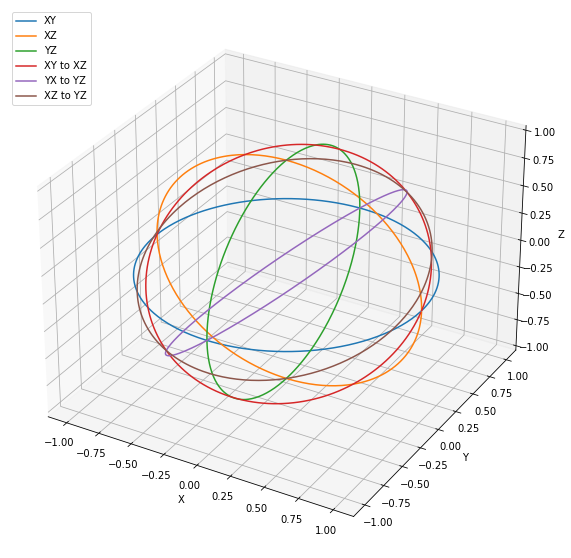

In [9]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
for plane in planes:
    ax.plot3D(x_values[plane], y_values[plane], z_values[plane], label=plane)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc ='upper left')

**Plotting conversion from *Cartesian* to *Spherical Polar* coordinates**

The plot of the *Cartersian* coordinates below shows the change in the X, Y and Z position of the points along each of the differently orientated circles for different rotation angles (${\alpha}$). 

The plot of the *Spherical Polar* coordinates below show the corresponding polar (${\theta}$) and azimuthal (${\phi}$) angles for each of these points around the circle. These values can also be plotted against the rotation angle, which are better represented by the count of the intensity data (at 1${^\circ}$ resolution), as is usually the case when the intesnities of the individual lattice planes are extracted from Continuous-Peak-Fit.

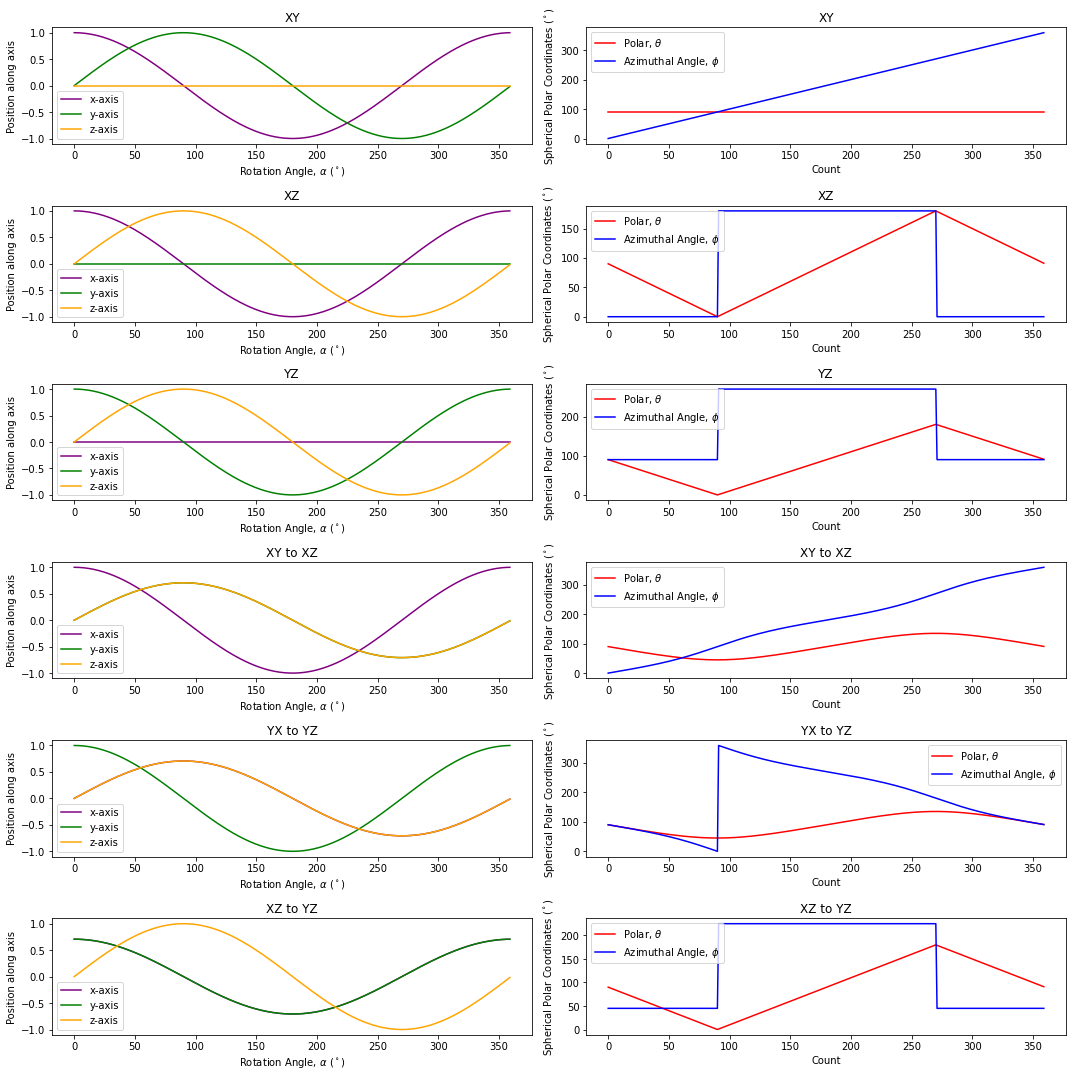

In [13]:
count=1
plt.subplots(figsize=(15, 15))

for plane in planes:    
    plt.subplot(6,2,count)
    plt.plot(x_values[plane], color = 'purple', label = r'x-axis')
    plt.plot(y_values[plane], color = 'green', label = r'y-axis')
    plt.plot(z_values[plane], color = 'orange', label = r'z-axis')
    plt.xlabel(r'Rotation Angle, ${\alpha}$ (${^\circ}$)')
    plt.ylabel(r'Position along axis')
    plt.title(plane)
    plt.legend()
    plt.tight_layout()
    count+=1
                
    plt.subplot(6,2,count)
    plt.plot(polar[plane], color = 'red', label = r'Polar, ${\theta}$')
    plt.plot(azimuth[plane], color ='blue', label = r'Azimuthal Angle, ${\phi}$')
    plt.title(plane)
    plt.xlabel(r'Count')
    plt.ylabel(r'Spherical Polar Coordinates (${^\circ}$)')
    plt.legend()
    plt.tight_layout()       
    count+=1            
                
plt.show()

**Parameterising any sample orientation [TODO]** 

Extending the above parameterisation of circles in 3D we can develop rotation matrices that calculate the points around any circle tilted in 3D. These calculations also account for the Bragg 2${\theta}$ scattering angle, which requires a small correction as the lattice planes are not exactly parrallel with the synchrotron X-ray beam to be within the diffraction condition.

The analysis below is based on clauclations presented in this [paper](https://doi.org/10.1107/S0021889811012064)

In [15]:
theta = np.deg2rad(0)

omega = np.deg2rad(0)
chi = np.deg2rad(0)
phi = np.deg2rad(0)

x_values=[]
y_values=[]
z_values=[]
magnitude=[]

polar=[]
azimuth=[]

resolution = 1
number_iterations = int((359 / resolution) + 1)

# draw the circle from 0 to 360 degrees
for gamma in np.linspace(0,359,number_iterations):
    
    gamma_rad = np.deg2rad(gamma)

    g_basis_vector = np.array([[1],[0],[0]])

    R_omega = np.array([[np.cos(omega), -np.sin(omega), 0],
                       [np.sin(omega), np.cos(omega), 0],
                       [0, 0, 1]])

    R_chi = np.array([[np.cos(chi), 0, np.sin(chi)],
                      [0, 1, 0],
                      [-np.sin(chi), 0, np.cos(chi)]])

    R_phi = np.array([[np.cos(phi), -np.sin(phi), 0],
                      [np.sin(phi), np.cos(phi), 0],
                      [0, 0, 1]])

    R_theta = np.array([[np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta), np.cos(theta), 0],
                        [0, 0, 1]])

    R_gamma = np.array([[np.cos(gamma_rad), 0, np.sin(gamma_rad)],
                        [0, 1, 0],
                        [-np.sin(gamma_rad), 0, np.cos(gamma_rad)]])
    
    R_omega_inv = np.linalg.inv(R_omega)
    R_chi_inv = np.linalg.inv(R_chi)
    R_phi_inv = np.linalg.inv(R_phi)
    
    #g_lattice_vector = np.matmul(np.matmul(np.matmul(np.matmul(np.matmul(R_phi_inv, R_chi_inv), R_gamma), R_omega_inv), R_theta), g_basis_vector)
    #g_lattice_vector = np.dot(np.dot(np.dot(np.dot(np.dot(R_phi_inv, R_chi_inv), R_gamma), R_omega_inv), R_theta), g_basis_vector)
    g_lattice_vector = np.matmul(np.matmul(np.matmul(np.matmul(R_phi_inv, R_chi_inv), R_gamma), R_omega_inv), g_basis_vector)
        
    x = float(g_lattice_vector[0])
    y = float(g_lattice_vector[1])
    z = float(g_lattice_vector[2])
    
    magnitude_g = np.linalg.norm(g_lattice_vector)
    theta = np.rad2deg(np.arccos(z))
    
    # calulate the spherical polar coordinates from cartesian coordinates using the standard equations
    theta = np.rad2deg(np.arccos(z))
    # arctan2 needed to handle negative values for phi values
    phi = np.rad2deg(np.arctan2(y,x))
    # convert phi scale from -180, 180 to 0, 360
    if phi < 0:
        phi = phi + 360

    # store the data in dictionaries
    magnitude.append(magnitude_g)
    x_values.append(x)
    y_values.append(y)
    z_values.append(z)
    polar.append(theta)
    azimuth.append(phi)

In [16]:
-np.sin(np.deg2rad(90))

-1.0

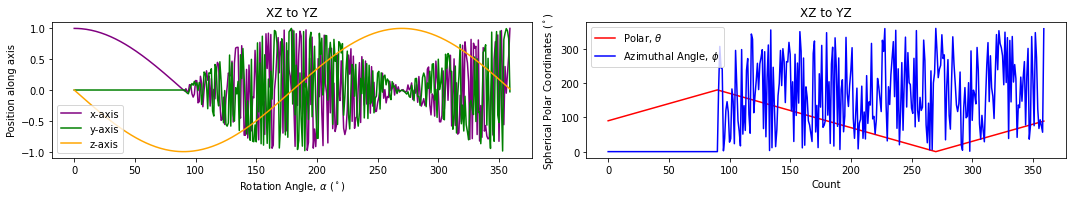

In [17]:
count=1
plt.subplots(figsize=(15, 15))
  
plt.subplot(6,2,count)
plt.plot(x_values, color = 'purple', label = r'x-axis')
plt.plot(y_values, color = 'green', label = r'y-axis')
plt.plot(z_values, color = 'orange', label = r'z-axis')
plt.xlabel(r'Rotation Angle, ${\alpha}$ (${^\circ}$)')
plt.ylabel(r'Position along axis')
plt.title(plane)
plt.legend()
plt.tight_layout()
count+=1

plt.subplot(6,2,count)
plt.plot(polar, color = 'red', label = r'Polar, ${\theta}$')
plt.plot(azimuth, color ='blue', label = r'Azimuthal Angle, ${\phi}$')
plt.title(plane)
plt.xlabel(r'Count')
plt.ylabel(r'Spherical Polar Coordinates (${^\circ}$)')
plt.legend()
plt.tight_layout()       
count+=1            
                
plt.show()